In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
import keras_tuner
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz

In [2]:
dt = pd.read_csv(r"C:\Users\sebex\Desktop\Magisterka\magisterka_implementacja\data\ECGCvdata.csv")
dt.head()

,RECORD,hbpermin,Pseg,PQseg,QRSseg,QRseg,QTseg,RSseg,STseg,Tseg,...,RMSSD,QRSarea,QRSperi,PQslope,QRslope,RSslope,STslope,NN50,pNN50,ECG_signal
0,1,74.925669,0.076508,0.108889,0.088254,0.043571,0.193016,0.044683,0.104762,0.130476,...,292.296636,18.457618,63.615239,-0.014364,0.075270,-0.070846,0.012606,2,5.882353,ARR
1,2,68.503469,0.072483,0.096181,0.093924,0.046267,0.193490,0.047656,0.099566,0.089149,...,318.563915,23.043230,67.787773,-0.021207,0.083773,-0.077458,0.016175,1,3.225806,ARR
2,3,83.488603,0.071154,0.086610,0.039530,0.018590,0.132479,0.020940,0.092949,0.094444,...,273.165412,10.756353,29.253827,-0.042542,NaN,NaN,0.027131,16,42.105263,ARR
3,4,68.503469,0.082812,0.108160,0.090365,0.045226,0.188802,0.045139,0.098437,0.088281,...,313.046941,23.845086,65.228737,-0.017806,0.091591,-0.088559,0.017022,2,6.451613,ARR
4,5,82.080000,0.070760,0.102632,0.101023,0.049415,0.193713,0.051608,0.092690,0.085965,...,263.225676,20.942791,72.830353,-0.016650,0.064547,-0.062246,0.016191,2,5.405405,ARR


In [3]:
# Drop "RECORD" column, which is redundant index
dt.drop(labels=["RECORD"], axis=1, inplace=True)
dt.head()

,hbpermin,Pseg,PQseg,QRSseg,QRseg,QTseg,RSseg,STseg,Tseg,PTseg,...,RMSSD,QRSarea,QRSperi,PQslope,QRslope,RSslope,STslope,NN50,pNN50,ECG_signal
0,74.925669,0.076508,0.108889,0.088254,0.043571,0.193016,0.044683,0.104762,0.130476,0.301905,...,292.296636,18.457618,63.615239,-0.014364,0.075270,-0.070846,0.012606,2,5.882353,ARR
1,68.503469,0.072483,0.096181,0.093924,0.046267,0.193490,0.047656,0.099566,0.089149,0.289670,...,318.563915,23.043230,67.787773,-0.021207,0.083773,-0.077458,0.016175,1,3.225806,ARR
2,83.488603,0.071154,0.086610,0.039530,0.018590,0.132479,0.020940,0.092949,0.094444,0.219088,...,273.165412,10.756353,29.253827,-0.042542,NaN,NaN,0.027131,16,42.105263,ARR
3,68.503469,0.082812,0.108160,0.090365,0.045226,0.188802,0.045139,0.098437,0.088281,0.296962,...,313.046941,23.845086,65.228737,-0.017806,0.091591,-0.088559,0.017022,2,6.451613,ARR
4,82.080000,0.070760,0.102632,0.101023,0.049415,0.193713,0.051608,0.092690,0.085965,0.296345,...,263.225676,20.942791,72.830353,-0.016650,0.064547,-0.062246,0.016191,2,5.405405,ARR


In [4]:
def fill_attr_with_lr(data: pd.DataFrame, attr_with_na: str, attr_without_na: str) -> None:
    """Fill attribute with empty records with linear regression using attribute
    without empty records.

    Parameters
    ----------
    data: pd.DataFrame
        DataFrame which includes involved attributes in the operation.
    attr_with_na: str
        Name of attribute with empty values to be filled.
    attr_without_na: str
        Name of attribute without empty values, needed to find linear regression factors.

    """
    tmp_dt = data[[attr_with_na, attr_without_na]].dropna(axis=0)
    a, b = np.polyfit(tmp_dt[attr_without_na], tmp_dt[attr_with_na], 1)
    data[attr_with_na].fillna(a * data[attr_without_na] + b, inplace=True)


In [5]:
fill_attr_with_lr(dt, "RSslope", "QRSperi")
fill_attr_with_lr(dt, "QRSang", "PPmean")
fill_attr_with_lr(dt, "RSTang", "PTdis")
fill_attr_with_lr(dt, "QRtoQSdur", "NNTot")
fill_attr_with_lr(dt, "PQRang", "PonTdis")
fill_attr_with_lr(dt, "PonPQang", "PonRdis")
fill_attr_with_lr(dt, "STToffang", "SToffdis")
fill_attr_with_lr(dt, "QRslope", "QRSang")
fill_attr_with_lr(dt, "RStoQSdur", "QRtoQSdur")

In [10]:
X = dt.drop(["ECG_signal"], axis=1)
y = dt["ECG_signal"]

# Standarization with 0-1 scale
X = (X - X.min()) / (X.max() - X.min())

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X,
                                                                y,
                                                                test_size=0.20,
                                                                stratify=y,
                                                                random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid,
                                                      y_train_valid,
                                                      test_size=0.20,
                                                      stratify=y_train_valid,
                                                      random_state=42)

In [11]:
y_train_2_cls = y_train.apply(lambda row: 0 if row == "NSR" else 1)
y_valid_2_cls = y_valid.apply(lambda row: 0 if row == "NSR" else 1)
y_test_2_cls = y_test.apply(lambda row: 0 if row == "NSR" else 1)
print(y_train_2_cls.value_counts())
print(y_valid_2_cls.value_counts())
print(y_test_2_cls.value_counts())
# y_test_encoded = le.fit_transform(y_test)

ECG_signal
1    576
0    192
Name: count, dtype: int64
ECG_signal
1    144
0     48
Name: count, dtype: int64
ECG_signal
1    180
0     60
Name: count, dtype: int64


In [25]:
X_train_hf_only = X_train.loc[dt["ECG_signal"] != "NSR"]
X_valid_hf_only = X_valid.loc[dt["ECG_signal"] != "NSR"]
X_test_hf_only = X_test.loc[dt["ECG_signal"] != "NSR"]
y_train_hf_only = y_train.loc[dt["ECG_signal"] != "NSR"]
y_valid_hf_only = y_valid.loc[dt["ECG_signal"] != "NSR"]
y_test_hf_only = y_test.loc[dt["ECG_signal"] != "NSR"]

diseases = {"ARR": 0, "AFF": 1, "CHF": 2}
y_train_hf_only = y_train_hf_only.apply(lambda row: diseases[row])
y_valid_hf_only= y_valid_hf_only.apply(lambda row: diseases[row])
y_test_hf_only = y_test_hf_only.apply(lambda row: diseases[row])

print(y_train_hf_only.value_counts())
print(y_valid_hf_only.value_counts())
print(y_test_hf_only.value_counts())


ECG_signal
2    192
0    192
1    192
Name: count, dtype: int64
ECG_signal
0    48
1    48
2    48
Name: count, dtype: int64
ECG_signal
1    60
2    60
0    60
Name: count, dtype: int64


In [28]:
# Classify into two classes: normal sinus rythm and diseases

# Klasyfikacja na dwie klasy: prawidłowy rytm sinusowy i na występowanie jakiejkolwiek dysfunkcji serca

inputs = keras.Input(shape=(54,))

x = layers.Dense(64, activation="relu")(inputs)
x = keras.layers.Dropout(rate=0.50)(x)

outputs = layers.Dense(2, activation="softmax")(x)
first_model = keras.Model(inputs=inputs, outputs=outputs)

first_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="ecg_hf_classification_first_model.keras",
        save_best_only=True,
        monitor="val_loss"),
        keras.callbacks.EarlyStopping(
        restore_best_weights=True,
        monitor='loss',
        patience=2)
]

history = first_model.fit(
    X_train, y_train_2_cls,
    epochs=100,
    batch_size=10,
    validation_data=(X_valid, y_valid_2_cls),
    callbacks=callbacks)

# Evaluating the model on the test set
first_test_model = keras.models.load_model("ecg_hf_classification_first_model.keras")
test_loss, test_acc = first_test_model.evaluate(X_test, y_test_2_cls, batch_size=100)
print(f"First model test accuracy: {test_acc:.3f}")

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6965 - loss: 0.5488 - val_accuracy: 1.0000 - val_loss: 0.1269
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9900 - loss: 0.1145 - val_accuracy: 1.0000 - val_loss: 0.0314
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0343 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 5.8719e-04
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 3.3252e-04
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.0182e-04 - val_accuracy

In [29]:
first_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,302 (28.53 KB)

 Trainable params: 3,650 (14.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,652 (14.27 KB)

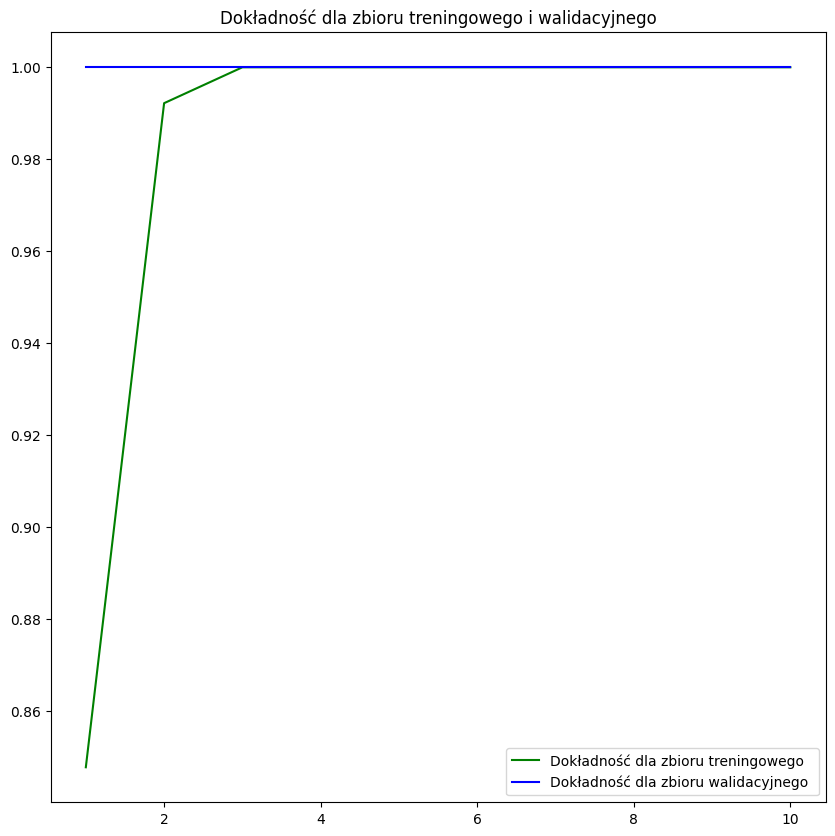

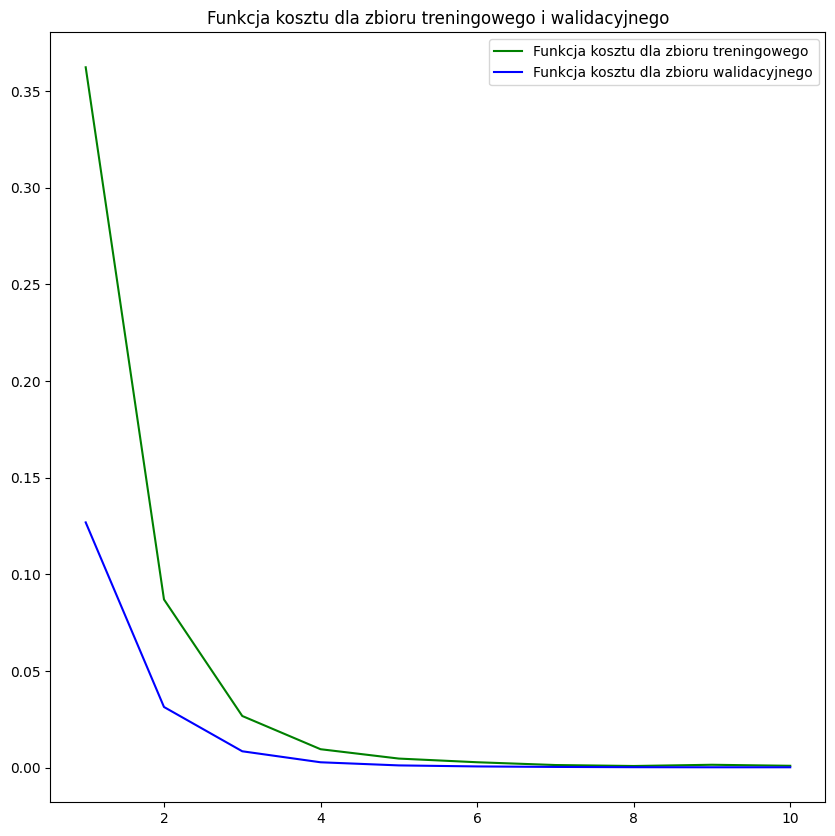

In [30]:
# Wykres diagnostyczny dla pierwszego modelu

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10, 10))
plt.plot(epochs, accuracy, "g", label="Dokładność dla zbioru treningowego ")
plt.plot(epochs, val_accuracy, "b", label="Dokładność dla zbioru walidacyjnego ")
plt.title("Dokładność dla zbioru treningowego i walidacyjnego")
plt.legend()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "g", label="Funkcja kosztu dla zbioru treningowego")
plt.plot(epochs, val_loss, "b", label="Funkcja kosztu dla zbioru walidacyjnego")
plt.title("Funkcja kosztu dla zbioru treningowego i walidacyjnego")
plt.legend()
plt.show()

In [33]:
# Classify into 3 classes (diseases)

# Klasyfikacja wyłącznie dysfunkcji serca na poszczególne przypadki

inputs = keras.Input(shape=(54,))

x = layers.Dense(64, activation="relu")(inputs)
x = keras.layers.Dropout(rate=0.5)(x)

x = layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(rate=0.5)(x)

x = layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(rate=0.5)(x)

x = layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(rate=0.5)(x)

x = layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(rate=0.5)(x)

outputs = layers.Dense(3, activation="softmax")(x)
second_model = keras.Model(inputs=inputs, outputs=outputs)

second_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="ecg_hf_classification_second_model.keras",
        save_best_only=True,
        monitor="val_loss"),
        keras.callbacks.EarlyStopping(
        restore_best_weights=True,
        monitor='loss',
        patience=10)
]

history = second_model.fit(
    X_train_hf_only, y_train_hf_only,
    epochs=200,
    batch_size=50,
    validation_data=(X_valid_hf_only, y_valid_hf_only),
    callbacks=callbacks)

# Evaluating the model on the test set
second_test_model = keras.models.load_model("ecg_hf_classification_second_model.keras")
test_loss, test_acc = second_test_model.evaluate(X_test_hf_only, y_test_hf_only, batch_size=100)
print(f"Second model test accuracy: {test_acc:.3f}")

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3612 - loss: 1.1270 - val_accuracy: 0.6250 - val_loss: 1.0039
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4804 - loss: 1.0330 - val_accuracy: 0.6319 - val_loss: 0.8296
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5748 - loss: 0.8802 - val_accuracy: 0.6458 - val_loss: 0.6065
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6100 - loss: 0.7702 - val_accuracy: 0.6667 - val_loss: 0.5190
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6412 - loss: 0.6672 - val_accuracy: 0.8194 - val_loss: 0.4713
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6823 - loss: 0.5584 - val_accuracy: 0.7986 - val_loss: 0.4446
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7299 - loss: 0.5286 - val_accuracy: 0.7986 - val_loss: 0.4241
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7527 - loss: 0.4878 - val_accuracy: 0.

In [34]:
second_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409,672 (5.38 MB)

 Trainable params: 704,835 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 704,837 (2.69 MB)

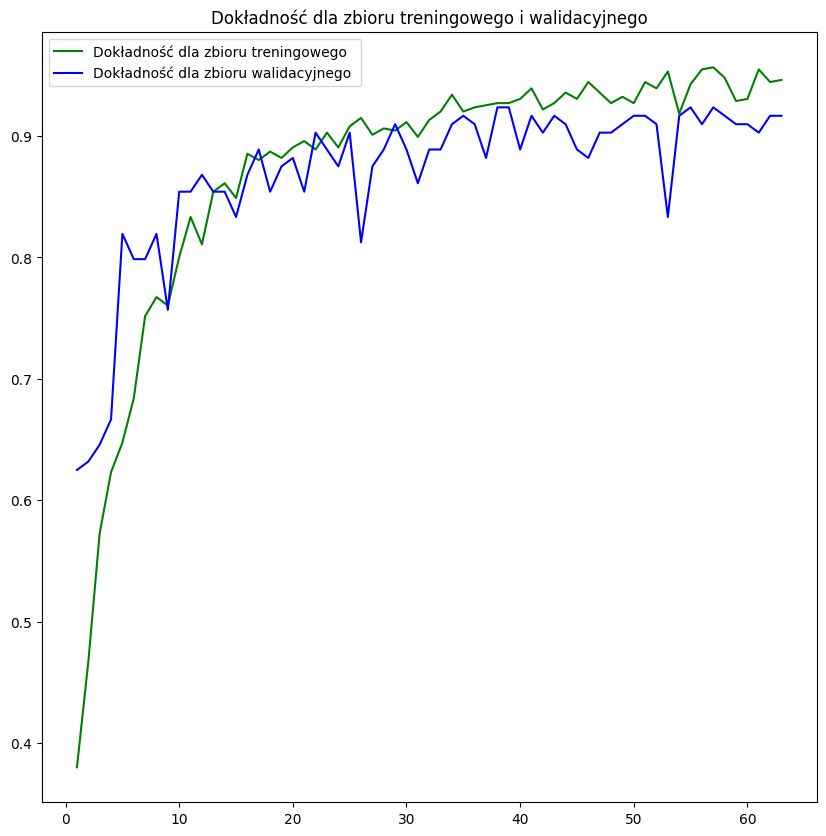

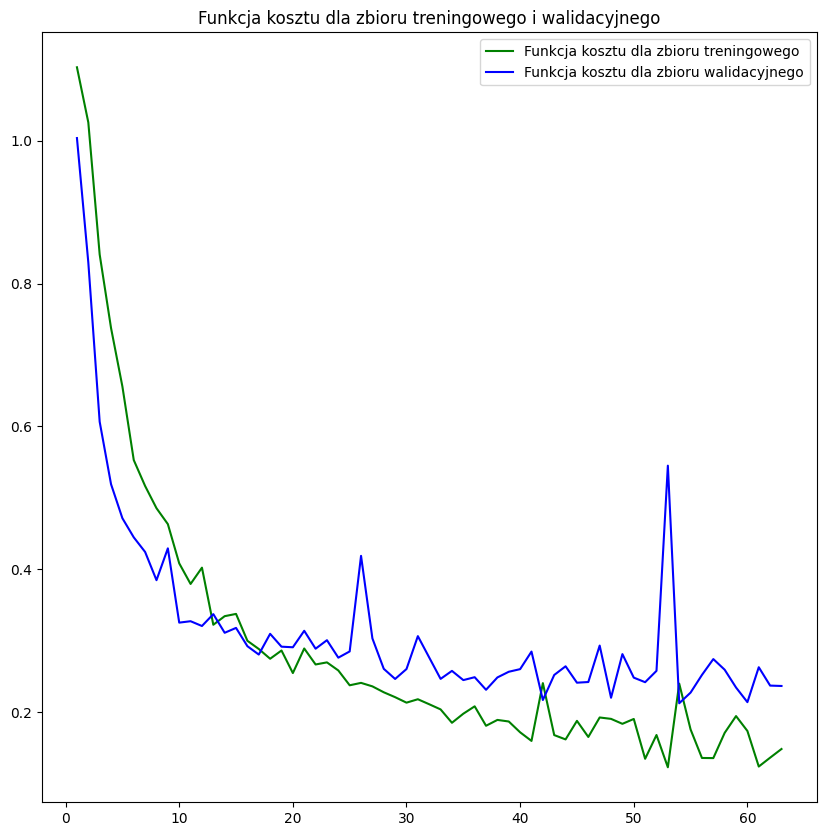

In [35]:
# Wykres diagnostyczny dla drugiego modelu

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10, 10))
plt.plot(epochs, accuracy, "g", label="Dokładność dla zbioru treningowego ")
plt.plot(epochs, val_accuracy, "b", label="Dokładność dla zbioru walidacyjnego ")
plt.title("Dokładność dla zbioru treningowego i walidacyjnego")
plt.legend()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "g", label="Funkcja kosztu dla zbioru treningowego")
plt.plot(epochs, val_loss, "b", label="Funkcja kosztu dla zbioru walidacyjnego")
plt.title("Funkcja kosztu dla zbioru treningowego i walidacyjnego")
plt.legend()
plt.show()

In [30]:
y_pred_2_cls = first_test_model.predict(X_test)
X_test_pred_hf_only = X_test.copy()
is_correct = 0

for i, X_test_idx in enumerate(X_test.index):
    print(f" I  Prediction is: {np.argmax(y_pred_2_cls[i])}, Right answer is: {y_test_2_cls.iloc[i]}")
    if np.argmax(y_pred_2_cls[i]) == 0:
        X_test_pred_hf_only.drop(index=X_test_idx, axis=0, inplace=True)

    if np.argmax(y_pred_2_cls[i]) == y_test_2_cls.iloc[i] == 0:
        is_correct += 1

y_pred_hf_only = second_test_model.predict(X_test_pred_hf_only)
for i, X_test_idx in enumerate(X_test_pred_hf_only.index):
    print(f" II Prediction is: {np.argmax(y_pred_hf_only[i])}, Right answer is: {y_hf_only.iloc[X_test_idx]}")
    if np.argmax(y_pred_hf_only[i]) == y_hf_only.iloc[X_test_idx]:
        is_correct += 1

accuracy = round(is_correct / len(X_test) * 100, 2)
print(f"Accuracy of test data predicting is: {accuracy} %")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 

In [ ]:
y_pred_2_cls = pd.Series(map(np.argmax, first_test_model.predict(X_test)), index=X_test.index)
X_test_as_hf = X_test.loc[y_pred_2_cls == 1]
y_pred_hf_only = pd.Series(map(np.argmax, second_test_model.predict(X_test_as_hf)), index=X_test_as_hf.index)
y_pred_hf_only = y_pred_hf_only.apply(lambda row: list(diseases.keys())[list(diseases.values()).index(row)])
y_pred_all = y_pred_2_cls.apply(lambda row: "NSR" if row == 0 else 1)
y_pred_all.update(y_pred_hf_only)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_all) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_all, y_test):
    assertion = "correct" if yp == yt else "wrong"
    print(f"Prediction: {yp}, actual value: {yt} ==> {assertion}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 96.25 %
F1_score: 96.25 %
Recall: 96.25 %
Precision: 96.3 %
Prediction: AFF, actual value: AFF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Predict

In [79]:
# Define Decision Tree Classifier parameters to be tested by Grid Search CV
first_clf = DecisionTreeClassifier(random_state=42)
path = first_clf.cost_complexity_pruning_path(X_train, y_train_2_cls)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print("ccp_alphas: \n", ccp_alphas) 

# Find best Decision Tree Classifier model parameters via Grid Search CV
parameters = {'ccp_alpha': ccp_alphas, 'max_depth': list(range(1, 10, 1)), 'max_leaf_nodes': list(range(2, 10, 1))}
gsc = GridSearchCV(first_clf, parameters)
gsc.fit(X_valid, y_valid_2_cls)
print(f"Best params: {gsc.best_params_}")
print(f"Best score: {gsc.best_score_}")

# Train best Desicion Tree Classifier model
first_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=gsc.best_params_["ccp_alpha"], max_depth=gsc.best_params_["max_depth"], max_leaf_nodes=gsc.best_params_["max_leaf_nodes"])
print(f"cross val score: {cross_val_score(first_clf, X_valid, y_valid_2_cls, cv=4)}")
print(f"mean: {np.mean(cross_val_score(first_clf, X_valid, y_valid_2_cls, cv=4))}")
first_clf.fit(X_train, y_train_2_cls)
y_pred_2_cls = first_clf.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test_2_cls, y_pred_2_cls) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_2_cls, y_test_2_cls):
    print(f"Prediction: {yp}, actual value: {yt}")

ccp_alphas: 
 [0.    0.375]
Best params: {'ccp_alpha': 0.0, 'max_depth': 1, 'max_leaf_nodes': 2}
Best score: 1.0
cross val score: [1. 1. 1. 1.]
mean: 1.0
Accuracy: 100.0 %
F1_score: 100.0 %
Recall: 100.0 %
Precision: 100.0 %
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1


In [80]:
export_graphviz(
  first_clf,
  out_file="first_tree.dot",
  feature_names=X.columns,
  class_names=["NSR" , "DIS"],
  rounded=True,
  filled=True
 )

In [81]:
# Define Decision Tree Classifier parameters to be tested by Grid Search CV
second_clf = DecisionTreeClassifier(random_state=42)
path = second_clf.cost_complexity_pruning_path(X_train_hf_only, y_train_hf_only)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print("ccp_alphas: \n", ccp_alphas) 

# Find best Decision Tree Classifier model parameters via Grid Search CV
parameters = {'ccp_alpha': ccp_alphas, 'max_depth': list(range(1, 10, 1)), 'max_leaf_nodes': list(range(2, 10, 1))}
gsc = GridSearchCV(second_clf, parameters)
gsc.fit(X_train_hf_only, y_train_hf_only)
print(f"Best params: {gsc.best_params_}")
print(f"Best score: {gsc.best_score_}")

# Train best Desicion Tree Classifier model
second_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=gsc.best_params_["ccp_alpha"], max_depth=gsc.best_params_["max_depth"], max_leaf_nodes=gsc.best_params_["max_leaf_nodes"])
print(f"cross val score: {cross_val_score(second_clf, X_valid_hf_only, y_valid_hf_only, cv=4)}")
print(f"mean: {np.mean(cross_val_score(second_clf, X_valid_hf_only, y_valid_hf_only, cv=4))}")
second_clf.fit(X_train_hf_only, y_train_hf_only)
y_pred_hf_only = second_clf.predict(X_test_hf_only)

print(f"Accuracy: {round(accuracy_score(y_test_hf_only, y_pred_hf_only) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_hf_only, y_test_hf_only):
    print(f"Prediction: {yp}, actual value: {yt}")

ccp_alphas: 
 [0.         0.00173611 0.00260417 0.00307457 0.00308642 0.003125
 0.00325458 0.00336372 0.00345423 0.00632424 0.00893787 0.01023595
 0.01063141 0.01394631 0.02118607 0.04200873 0.18628954 0.33074942]
Best params: {'ccp_alpha': 0.0, 'max_depth': 6, 'max_leaf_nodes': 9}
Best score: 0.9462218890554723
cross val score: [0.91666667 0.83333333 0.88888889 0.97222222]
mean: 0.9027777777777778
Accuracy: 93.33 %
F1_score: 93.3 %
Recall: 93.33 %
Precision: 93.3 %
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Pr

In [82]:
y_pred_2_cls = pd.Series(first_clf.predict(X_test), index=X_test.index)
X_test_as_hf = X_test.loc[y_pred_2_cls == 1]
y_pred_hf_only = pd.Series(second_clf.predict(X_test_as_hf), index=X_test_as_hf.index)
y_pred_hf_only = y_pred_hf_only.apply(lambda row: list(diseases.keys())[list(diseases.values()).index(row)])
y_pred_all = y_pred_2_cls.apply(lambda row: "NSR" if row == 0 else 1)
y_pred_all.update(y_pred_hf_only)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_all) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_all, y_test):
    assertion = "correct" if yp == yt else "wrong"
    print(f"Prediction: {yp}, actual value: {yt} ==> {assertion}")

Accuracy: 95.0 %
F1_score: 94.98 %
Recall: 95.0 %
Precision: 94.98 %
Prediction: AFF, actual value: AFF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: AFF, actual value: AFF ==>

In [ ]:
# Train Desicion Tree Classifier model
first_clf = DecisionTreeClassifier(random_state=42)
first_clf.fit(X_train, y_train_2_cls)
y_pred_2_cls = first_clf.predict(X_test)

print(f"cross val score: {cross_val_score(first_clf, X_valid, y_valid_2_cls, cv=4)}")
print(f"mean: {np.mean(cross_val_score(first_clf, X_valid, y_valid_2_cls, cv=4))}")
print(f"Accuracy: {round(accuracy_score(y_test_2_cls, y_pred_2_cls) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_2_cls, y_test_2_cls):
    print(f"Prediction: {yp}, actual value: {yt}")

export_graphviz(
  first_clf,
  out_file="first_tree.dot",
  feature_names=X.columns,
  class_names=["NSR" , "DIS"],
  rounded=True,
  filled=True
 )

cross val score: [1. 1. 1. 1.]
mean: 1.0
Accuracy: 100.0 %
F1_score: 100.0 %
Recall: 100.0 %
Precision: 100.0 %
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actua

In [ ]:
first_clf = DecisionTreeClassifier(random_state=42)
first_clf.fit(X_train, y_train_2_cls)
y_pred_2_cls = first_clf.predict(X_test)

second_clf = DecisionTreeClassifier(random_state=42)
second_clf.fit(X_train_hf_only, y_train_hf_only)
y_pred_hf_only = second_clf.predict(X_test_hf_only)

In [84]:
# Train best Desicion Tree Classifier model
second_clf = DecisionTreeClassifier(random_state=42)
second_clf.fit(X_train_hf_only, y_train_hf_only)
y_pred_hf_only = second_clf.predict(X_test_hf_only)

print(f"cross val score: {cross_val_score(second_clf, X_valid_hf_only, y_valid_hf_only, cv=4)}")
print(f"mean: {np.mean(cross_val_score(second_clf, X_valid_hf_only, y_valid_hf_only, cv=4))}")
print(f"Accuracy: {round(accuracy_score(y_test_hf_only, y_pred_hf_only) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_hf_only, y_test_hf_only):
    print(f"Prediction: {yp}, actual value: {yt}")

export_graphviz(
  second_clf,
  out_file="second_tree.dot",
  feature_names=X.columns,
  class_names=["ARR", "AFF", "CHF"],
  rounded=True,
  filled=True
 )

cross val score: [0.91666667 0.83333333 0.88888889 0.97222222]
mean: 0.9027777777777778
Accuracy: 91.67 %
F1_score: 91.6 %
Recall: 91.67 %
Precision: 91.71 %
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Predi

In [85]:
y_pred_2_cls = pd.Series(first_clf.predict(X_test), index=X_test.index)
X_test_as_hf = X_test.loc[y_pred_2_cls == 1]
y_pred_hf_only = pd.Series(second_clf.predict(X_test_as_hf), index=X_test_as_hf.index)
y_pred_hf_only = y_pred_hf_only.apply(lambda row: list(diseases.keys())[list(diseases.values()).index(row)])
y_pred_all = y_pred_2_cls.apply(lambda row: "NSR" if row == 0 else 1)
y_pred_all.update(y_pred_hf_only)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_all) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_all, y_test):
    assertion = "correct" if yp == yt else "wrong"
    print(f"Prediction: {yp}, actual value: {yt} ==> {assertion}")

Accuracy: 93.75 %
F1_score: 93.7 %
Recall: 93.75 %
Precision: 93.78 %
Prediction: AFF, actual value: AFF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: AFF, actual value: AFF ==

In [86]:
# Train Random Forest Classifier model
first_rfc = RandomForestClassifier(random_state=42)
first_rfc.fit(X_train, y_train_2_cls)
y_pred_2_cls = first_rfc.predict(X_test)
print(f"cross val score: {round(np.mean(cross_val_score(first_rfc, X_valid, y_valid_2_cls, cv=4)) * 100, 2)} %")
print(f"Accuracy_score: {round(accuracy_score(y_test_2_cls, y_pred_2_cls) * 100, 2)} %")
print(f"Accuracy: {round(accuracy_score(y_test_2_cls, y_pred_2_cls) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_2_cls, y_test_2_cls):
    print(f"Prediction: {yp}, actual value: {yt}")

cross val score: 100.0 %
Accuracy_score: 100.0 %
Accuracy: 100.0 %
F1_score: 100.0 %
Recall: 100.0 %
Precision: 100.0 %
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 

In [ ]:
first_rfc = RandomForestClassifier(random_state=42)
first_rfc.fit(X_train, y_train_2_cls)
y_pred_2_cls = first_rfc.predict(X_test)

second_rfc = RandomForestClassifier(random_state=42, n_estimators=40)
second_rfc.fit(X_train_hf_only, y_train_hf_only)
y_pred_hf_only = second_rfc.predict(X_test_hf_only)

In [87]:
# Train Random Forest Classifier model
second_rfc = RandomForestClassifier(random_state=42, n_estimators=40)
second_rfc.fit(X_train_hf_only, y_train_hf_only)
y_pred_hf_only = second_rfc.predict(X_test_hf_only)
print(f"cross val score: {round(np.mean(cross_val_score(second_rfc, X_valid_hf_only, y_valid_hf_only, cv=4)) * 100, 2)} %")
print(f"Accuracy_score: {round(accuracy_score(y_test_hf_only, y_pred_hf_only) * 100, 2)} %")
print(f"Accuracy: {round(accuracy_score(y_test_hf_only, y_pred_hf_only) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_hf_only, y_test_hf_only):
    print(f"Prediction: {yp}, actual value: {yt}")

cross val score: 93.06 %
Accuracy_score: 95.56 %
Accuracy: 95.56 %
F1_score: 95.54 %
Recall: 95.56 %
Precision: 95.54 %
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 

In [88]:
y_pred_2_cls = pd.Series(first_rfc.predict(X_test), index=X_test.index)
X_test_as_hf = X_test.loc[y_pred_2_cls == 1]
y_pred_hf_only = pd.Series(second_rfc.predict(X_test_as_hf), index=X_test_as_hf.index)
y_pred_hf_only = y_pred_hf_only.apply(lambda row: list(diseases.keys())[list(diseases.values()).index(row)])
y_pred_all = y_pred_2_cls.apply(lambda row: "NSR" if row == 0 else 1)
y_pred_all.update(y_pred_hf_only)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_all) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_all, y_test):
    assertion = "correct" if yp == yt else "wrong"
    print(f"Prediction: {yp}, actual value: {yt} ==> {assertion}")

Accuracy: 96.67 %
F1_score: 96.65 %
Recall: 96.67 %
Precision: 96.66 %
Prediction: AFF, actual value: AFF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: AFF, actual value: AFF =

In [39]:
y_pred_2_cls = first_rfc.predict(X_test)
X_test_pred_hf_only = X_test.copy()
is_correct = 0

for i, X_test_idx in enumerate(X_test.index):
    print(f" I  Prediction is: {y_pred_2_cls[i]}, Right answer is: {y_test_2_cls.iloc[i]}")
    if y_pred_2_cls[i] == 0:
        X_test_pred_hf_only.drop(index=X_test_idx, axis=0, inplace=True)

    if y_pred_2_cls[i] == y_test_2_cls.iloc[i] == 0:
        is_correct += 1

y_pred_hf_only = second_rfc.predict(X_test_pred_hf_only)
for i, X_test_idx in enumerate(X_test_pred_hf_only.index):
    print(f" II Prediction is: {y_pred_hf_only[i]}, Right answer is: {y_hf_only.iloc[X_test_idx]}")
    if y_pred_hf_only[i] == y_hf_only.iloc[X_test_idx]:
        is_correct += 1

accuracy = round(is_correct / len(X_test) * 100, 2)
print(f"Accuracy of test data predicting is: {accuracy} %")

 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 1, Right answer is: 1
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 0, Right answer is: 0
 I  Prediction is: 1, Right answer is: 1
 I  Prediction i

In [40]:
# Find best Random Forest Classifier model parameters via Grid Search CV
rfc = RandomForestClassifier(random_state=42)
parameters = {'ccp_alpha': list(np.arange(0, 0.5, 0.05)), 'max_depth': list(range(1, 10, 1)), 'max_leaf_nodes': list(range(2, 10, 1))}
gsc = GridSearchCV(rfc, parameters)
gsc.fit(X_valid, y_valid)
print(f"Best params: {gsc.best_params_}")
print(f"Best score: {gsc.best_score_}")

Best params: {'ccp_alpha': 0.0, 'max_depth': 6, 'max_leaf_nodes': 8}
Best score: 0.9476383265856949


In [41]:
# Train best Random Forest Classifier model
rfc = RandomForestClassifier(random_state=42, ccp_alpha=gsc.best_params_["ccp_alpha"], max_depth=gsc.best_params_["max_depth"], max_leaf_nodes=gsc.best_params_["max_leaf_nodes"])
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f"Cross val score: {np.mean(cross_val_score(rfc, X_valid, y_valid, cv=4))}")
print(f"Accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f'F1_score: {f1_score(y_test, y_pred, average="macro")}')
print(f'Recall: {recall_score(y_test, y_pred, average="macro")}')
print(f'Precision: {precision_score(y_test, y_pred, average="macro")}')
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")

Cross val score: 0.9427083333333334
Accuracy_score: 0.9666666666666667
Accuracy: 0.9666666666666667
F1_score: 0.966523108270816
Recall: 0.9666666666666667
Precision: 0.9666481275491288
Prediction: AFF, actual value: AFF
Prediction: CHF, actual value: CHF
Prediction: NSR, actual value: NSR
Prediction: ARR, actual value: ARR
Prediction: NSR, actual value: NSR
Prediction: AFF, actual value: AFF
Prediction: ARR, actual value: ARR
Prediction: ARR, actual value: ARR
Prediction: AFF, actual value: AFF
Prediction: CHF, actual value: CHF
Prediction: ARR, actual value: ARR
Prediction: NSR, actual value: NSR
Prediction: ARR, actual value: ARR
Prediction: ARR, actual value: ARR
Prediction: CHF, actual value: CHF
Prediction: CHF, actual value: CHF
Prediction: CHF, actual value: CHF
Prediction: CHF, actual value: CHF
Prediction: AFF, actual value: AFF
Prediction: AFF, actual value: AFF
Prediction: NSR, actual value: NSR
Prediction: NSR, actual value: NSR
Prediction: NSR, actual value: NSR
Prediction

In [42]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f"Cross val score: {np.mean(cross_val_score(rfc, X_valid, y_valid, cv=4))}")
print(f"Accuracy_score: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f'F1_score: {f1_score(y_test, y_pred, average="macro")}')
print(f'Recall: {recall_score(y_test, y_pred, average="macro")}')
print(f'Precision: {precision_score(y_test, y_pred, average="macro")}')
for yp, yt in zip(y_pred, y_test):
    print(f"Prediction: {yp}, actual value: {yt}")

Cross val score: 0.9635416666666666
Accuracy_score: 0.9666666666666667
Accuracy: 0.9666666666666667
F1_score: 0.9665219218377923
Recall: 0.9666666666666667
Precision: 0.9665771622385528
Prediction: AFF, actual value: AFF
Prediction: CHF, actual value: CHF
Prediction: NSR, actual value: NSR
Prediction: ARR, actual value: ARR
Prediction: NSR, actual value: NSR
Prediction: AFF, actual value: AFF
Prediction: ARR, actual value: ARR
Prediction: ARR, actual value: ARR
Prediction: AFF, actual value: AFF
Prediction: CHF, actual value: CHF
Prediction: ARR, actual value: ARR
Prediction: NSR, actual value: NSR
Prediction: ARR, actual value: ARR
Prediction: ARR, actual value: ARR
Prediction: CHF, actual value: CHF
Prediction: CHF, actual value: CHF
Prediction: CHF, actual value: CHF
Prediction: CHF, actual value: CHF
Prediction: AFF, actual value: AFF
Prediction: AFF, actual value: AFF
Prediction: NSR, actual value: NSR
Prediction: NSR, actual value: NSR
Prediction: NSR, actual value: NSR
Predictio

In [89]:
first_clf = LogisticRegression(random_state=42, C=1000.0)
first_clf.fit(X_train, y_train_2_cls)
y_pred_2_cls= first_clf.predict(X_test)
print(f"cross val score: {round(np.mean(cross_val_score(first_clf, X_valid, y_valid_2_cls, cv=4)) * 100, 2)} %")
print(f"Accuracy_score: {round(accuracy_score(y_test_2_cls, y_pred_2_cls) * 100, 2)} %")
print(f"Accuracy: {round(accuracy_score(y_test_2_cls, y_pred_2_cls) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test_2_cls, y_pred_2_cls, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_2_cls, y_test_2_cls):
    print(f"Prediction: {yp}, actual value: {yt}")

cross val score: 100.0 %
Accuracy_score: 100.0 %
Accuracy: 100.0 %
F1_score: 100.0 %
Recall: 100.0 %
Precision: 100.0 %
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 

In [ ]:
first_clf = LogisticRegression(random_state=42, C=1000.0)
first_clf.fit(X_train, y_train_2_cls)
y_pred_2_cls= first_clf.predict(X_test)

second_clf = LogisticRegression(random_state=42, C=1000.0)
second_clf.fit(X_train_hf_only, y_train_hf_only)
y_pred_hf_only = second_clf.predict(X_test_hf_only)

In [95]:
second_clf = LogisticRegression(random_state=42, C=1000.0)
second_clf.fit(X_train_hf_only, y_train_hf_only)
y_pred_hf_only = second_clf.predict(X_test_hf_only)
print(f"cross val score: {round(np.mean(cross_val_score(second_clf, X_valid_hf_only, y_valid_hf_only, cv=4)) * 100, 2)} %")
print(f"Accuracy_score: {round(accuracy_score(y_test_hf_only, y_pred_hf_only) * 100, 2)} %")
print(f"Accuracy: {round(accuracy_score(y_test_hf_only, y_pred_hf_only) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test_hf_only, y_pred_hf_only, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_hf_only, y_test_hf_only):
    print(f"Prediction: {yp}, actual value: {yt}")

cross val score: 89.58 %
Accuracy_score: 98.33 %
Accuracy: 98.33 %
F1_score: 98.33 %
Recall: 98.33 %
Precision: 98.41 %
Prediction: 2, actual value: 1
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 0, actual value: 0
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 2, actual value: 2
Prediction: 0, actual value: 0
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 2, actual value: 2
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 1, actual value: 1
Prediction: 

c:\Users\sebex\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sebex\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [96]:
y_pred_2_cls = pd.Series(first_clf.predict(X_test), index=X_test.index)
X_test_as_hf = X_test.loc[y_pred_2_cls == 1]
y_pred_hf_only = pd.Series(second_clf.predict(X_test_as_hf), index=X_test_as_hf.index)
y_pred_hf_only = y_pred_hf_only.apply(lambda row: list(diseases.keys())[list(diseases.values()).index(row)])
y_pred_all = y_pred_2_cls.apply(lambda row: "NSR" if row == 0 else 1)
y_pred_all.update(y_pred_hf_only)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred_all) * 100, 2)} %")
print(f'F1_score: {round(f1_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
print(f'Recall: {round(recall_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
print(f'Precision: {round(precision_score(y_test, y_pred_all, average="macro") * 100, 2)} %')
for yp, yt in zip(y_pred_all, y_test):
    assertion = "correct" if yp == yt else "wrong"
    print(f"Prediction: {yp}, actual value: {yt} ==> {assertion}")

Accuracy: 98.75 %
F1_score: 98.75 %
Recall: 98.75 %
Precision: 98.81 %
Prediction: CHF, actual value: AFF ==> wrong
Prediction: CHF, actual value: CHF ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: NSR, actual value: NSR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: ARR, actual value: ARR ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: CHF, actual value: CHF ==> correct
Prediction: AFF, actual value: AFF ==> correct
Prediction: AFF, actual value: AFF ==>